<a href="https://colab.research.google.com/github/mccarthyajb/RNNAdversarialRobustness/blob/main/Shared_with_Supers_FGSM_%26_PGD_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Some Globals

In [ ]:
DEBUG = 0

COUNT_MAL_FLOWS = 1
IF_ANY_MAL_SEQ_MAL = 0
INSTANCE_BASED = 0 

#Network parameters

#timesteps_todo = [ 1 ]
#timesteps_todo = [ 1,2,3,4,5,6,7,8,9,10 ]
timesteps_todo = [ 10,20,30,40,50,60,70,80,90,100, 110, 120, 130, 140, 150 ]
max_timesteps = 10
by_increment = 1
#epochs = 1000
epochs = 200
dropout = 0.20
batchSize = 32

plot_timesteps = []
unseen_test_accuracy = []
advx_accuracy = []
unseen_loss = []
f1Scores = []
advx_f1Scores = []

#Train test split

testSize = 0.3

DO_THE_ADVERSARIAL_EXAMPLE = 1 

#FGSM 
epsilon =  1.0

DO_FGSM = 0
DO_PGD = 1
DO_JSMA = 0

USE_RNN = 0
USE_LSTM = 1
USE_GRU = 0


## Versions

In [ ]:
# https://keras.io/examples/timeseries/timeseries_classification_from_scratch/

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# !pip uninstall scikit-learn -y

# !pip install -U scikit-learn

import sklearn

sklearn.__version__
if(sklearn.__version__ == '0.22.2.post1'):
  print("We need a newer version of sklearn")
  !pip uninstall scikit-learn -y
  !pip install -U scikit-learn
  raise SystemExit("Stop right there! Restart the Kernel")




## Open and process dataset

In [ ]:
import pandas as pd
import csv

from google.colab import drive
drive.mount('./mount')
print("Drive Mounted")

# Load in the dataset
df = pd.read_csv('mount/My Drive/Colab Notebooks/CICIDS2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

# Remove NaN and Inf
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
# Remove columns with all zero values
df = df.loc[:, (df != 0).any(axis=0)]
# Output table
df

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).
Drive Mounted


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,9.0,6.0,0.0,40,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,1,9.0,6.0,6.0,20,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,1,9.0,6.0,6.0,20,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,1,9.0,6.0,6.0,20,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,9.0,6.0,0.0,40,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,61374,61,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.967213e+05,32786.88525,61.0,0.0,61,61,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,20,20,16393.442620,16393.442620,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,1,9.0,6.0,6.0,20,1,6,1,6,288,253,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225741,61378,72,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.666667e+05,27777.77778,72.0,0.0,72,72,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,20,20,13888.888890,13888.888890,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,1,9.0,6.0,6.0,20,1,6,1,6,288,253,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225742,61375,75,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.600000e+05,26666.66667,75.0,0.0,75,75,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,20,20,13333.333330,13333.333330,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,1,9.0,6.0,6.0,20,1,6,1,6,288,253,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225743,61323,48,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,2.500000e+05,41666.66667,48.0,0.0,48,48,48,48.0,0.0,48,48,0,0.0,0.0,0,0,0,40,0,41666.666670,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,9.0,6.0,0.0,40,2,12,0,0,4719,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


## Reduce to most important Features

In [ ]:
print(df.columns)
df = df[['Total Length of Fwd Packets', 
        # 'CWE Flag Count',
        ' Fwd Packet Length Max',
        'Subflow Fwd Packets',
        ' Flow IAT Max',
        ' Subflow Bwd Packets',
         ' Total Fwd Packets',
         ' Flow IAT Mean',
         'Fwd PSH Flags',
         ' Down/Up Ratio',
         ' Fwd Packet Length Min',
         ' Flow IAT Std',
         ' Flow IAT Min',
         ' URG Flag Count',
         ' Subflow Fwd Bytes', 
         ' Bwd Packet Length Min',
         ' Label'
         ]]

df


        # 2  N & \_CWE\_Flag\_Count & Congestion Window Flag\\  
        # 3  Y & \_Fwd\_Packet\_Length\_Max & Max Forward Packet Length \\
        # 4  N \_Bwd\_Avg\_Bytes/Bulk & Average No. Backward Bytes/Bulk\\
        # 5  Y \ Subflow\_Fwd\_Packets& Number of Forward Packets in a Subflow\\
        # 6  Y \_Flow\_IAT\_Max & Maximum Inter-Arrival for a flow\\
        # 7  Y \_Subflow\_Bwd\_Packets & No. Backward Packets in Subflow\\
        # 8  Y \_Total\_Fwd\_Packets & Total Forward Packets\\
        # 9  Y \_Flow\_IAT\_Mean & Mean Inter-Arrival\\
        # 10 Y & Fwd\_PSH\_Flags & Forward Push Flag\\
        # 11 Y \_Down/Up\_Ratio & Down/Up Ratio\\
        # 12 N \_Source\_Port & Source Port\\
        # 13 N & \_Protocol &  Protocol\\
        # 14 Y \_Fwd\_Packet\_Length\_Min & Minimum Forward Packet Length\\
        # 15 Y & \_Flow\_IAT\_Std & Inter-Arrival Standard Deviation for flow\\
        # 16 Y & \_Flow\_IAT\_Min & Minimum Inter-Arrival Standard Deviation for flow\\
        # 17 Y & \_URG\_Flag\_Count & Urgent flag count\\
        # 18 N \_Fwd\_Avg\_Bulk\_Rate & Average No. Forward Bytes/Bulk\\
        # 19 Y & \_Subflow\_Fwd\_Bytes & No. forward bytes in subflow\\
        # 20 Y & \_Bwd\_Packet\_Length\_Min & Minimum backward packet length\\ ']

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count',
       ' SYN Flag Count', ' RST Flag Count',

,Total Length of Fwd Packets,Fwd Packet Length Max,Subflow Fwd Packets,Flow IAT Max,Subflow Bwd Packets,Total Fwd Packets,Flow IAT Mean,Fwd PSH Flags,Down/Up Ratio,Fwd Packet Length Min,Flow IAT Std,Flow IAT Min,URG Flag Count,Subflow Fwd Bytes,Bwd Packet Length Min,Label
0,12,6,2,3,0,2,3.0,0,0,6,0.0,3,0,12,0,BENIGN
1,6,6,1,109,1,1,109.0,0,1,6,0.0,109,1,6,6,BENIGN
2,6,6,1,52,1,1,52.0,0,1,6,0.0,52,1,6,6,BENIGN
3,6,6,1,34,1,1,34.0,0,1,6,0.0,34,1,6,6,BENIGN
4,12,6,2,3,0,2,3.0,0,0,6,0.0,3,0,12,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,6,6,1,61,1,1,61.0,0,1,6,0.0,61,1,6,6,BENIGN
225741,6,6,1,72,1,1,72.0,0,1,6,0.0,72,1,6,6,BENIGN
225742,6,6,1,75,1,1,75.0,0,1,6,0.0,75,1,6,6,BENIGN
225743,12,6,2,48,0,2,48.0,0,0,6,0.0,48,0,12,0,BENIGN


In [ ]:
# What columns are left?
print (df.columns)
# How many columns?
print ("Length: ", len(df.columns))

Index(['Total Length of Fwd Packets', ' Fwd Packet Length Max',
       'Subflow Fwd Packets', ' Flow IAT Max', ' Subflow Bwd Packets',
       ' Total Fwd Packets', ' Flow IAT Mean', 'Fwd PSH Flags',
       ' Down/Up Ratio', ' Fwd Packet Length Min', ' Flow IAT Std',
       ' Flow IAT Min', ' URG Flag Count', ' Subflow Fwd Bytes',
       ' Bwd Packet Length Min', ' Label'],
      dtype='object')
Length:  16


In [ ]:
# Import scikit learn
from sklearn import preprocessing

# Creating X and Y from the dataset
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df[' Label'])
Y_attack = le.transform(df[' Label']) # multi-class 
Y_class = df.iloc[:,-1].values # binary

# Extract only the numerical feature columns
subset = df.iloc[:,0:15].astype(float)


        
# Define the scaler
min_max_scaler = preprocessing.MinMaxScaler()
# Apply the scaler to each column of our dataframe
df2 = pd.DataFrame(min_max_scaler.fit_transform(subset), columns=subset.columns, index=subset.index)
print(df2)

# Transform Objects to Digits
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for column_name in df2.columns:
        if df2[column_name].dtype == object:
            print(df2[column_name])
            df2[column_name] = le.fit_transform(df2[column_name])
        else:
            pass

print(Y_class)
Y_class = le.fit_transform(Y_class)
print(Y_class)
    

        Total Length of Fwd Packets  ...   Bwd Packet Length Min
0                          0.000066  ...                 0.00000
1                          0.000033  ...                 0.00411
2                          0.000033  ...                 0.00411
3                          0.000033  ...                 0.00411
4                          0.000066  ...                 0.00000
...                             ...  ...                     ...
225740                     0.000033  ...                 0.00411
225741                     0.000033  ...                 0.00411
225742                     0.000033  ...                 0.00411
225743                     0.000066  ...                 0.00000
225744                     0.000033  ...                 0.00411

[225711 rows x 15 columns]
['BENIGN' 'BENIGN' 'BENIGN' ... 'BENIGN' 'BENIGN' 'BENIGN']
[0 0 0 ... 0 0 0]


In [ ]:
# Output the classes
outcome = df[' Label'].unique()
print(outcome)

['BENIGN' 'DDoS']


In [ ]:
# print(df2.dtypes)
x_scaled = np.array(df2)

print("x_scaled=======================")
print(x_scaled)

#print(df[' Label'])
# # y_train = np.array(df[' Label'])

from sklearn.model_selection import train_test_split

# # x_train, x_test, y_train, y_test = train_test_split(x_scaled, Y_class, test_size = 0.7, shuffle=True, random_state = 42, stratify=Y_class)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, Y_class, test_size = testSize, shuffle=False, random_state = 42)

print("x_train=======================")

print(x_train)
print(x_train.shape)

print("y_train=======================")
print(y_train)
print(y_train.shape)



x_scaled=======================
[[6.55694709e-05 5.13698630e-04 5.17866390e-04 ... 0.00000000e+00
  6.55694709e-05 0.00000000e+00]
 [3.27847354e-05 5.13698630e-04 0.00000000e+00 ... 1.00000000e+00
  3.27847354e-05 4.10958904e-03]
 [3.27847354e-05 5.13698630e-04 0.00000000e+00 ... 1.00000000e+00
  3.27847354e-05 4.10958904e-03]
 ...
 [3.27847354e-05 5.13698630e-04 0.00000000e+00 ... 1.00000000e+00
  3.27847354e-05 4.10958904e-03]
 [6.55694709e-05 5.13698630e-04 5.17866390e-04 ... 0.00000000e+00
  6.55694709e-05 0.00000000e+00]
 [3.27847354e-05 5.13698630e-04 0.00000000e+00 ... 1.00000000e+00
  3.27847354e-05 4.10958904e-03]]
x_train=======================
[[6.55694709e-05 5.13698630e-04 5.17866390e-04 ... 0.00000000e+00
  6.55694709e-05 0.00000000e+00]
 [3.27847354e-05 5.13698630e-04 0.00000000e+00 ... 1.00000000e+00
  3.27847354e-05 4.10958904e-03]
 [3.27847354e-05 5.13698630e-04 0.00000000e+00 ... 1.00000000e+00
  3.27847354e-05 4.10958904e-03]
 ...
 [1.31138942e-04 5.13698630e-04 1.5

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print(x_train.shape)
print(x_test.shape)

(157997, 15, 1)
(67714, 15, 1)


In [ ]:
num_classes = len(np.unique(y_train))
print("There are "+ str(num_classes) +" distinct classes")
print(outcome)

There are 2 distinct classes
['BENIGN' 'DDoS']


## Some Functions 


In [ ]:
def CountofMalSamplesIn():

  global sequence_my_y_test

  print("Resetting sequence_my_y_test")
  sequence_my_y_test = []
  if(timesteps > 1):
    print("Timesteps > 1 :" + str(timesteps))
    print("for loop in range: " + str(range(len(my_y_test))))
    for seq in range(len(my_y_test)):
      #print("in the actual loop")
      # print(my_y_train[seq])
      list_to_check = my_y_test[seq].tolist()
      if(list_to_check.count(1) > 0 ):
        orig_my_y_train = my_y_test[seq]
        sequence_my_y_test.append(list_to_check.count(1))
        # print("`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`")
        # print("original: "+ str(orig_my_y_train) + " Modified " + str(sequence_my_y_train[seq]))
      else:
        orig_my_y_train = my_y_test[seq]
        sequence_my_y_test.append(0)
        # print("`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`")
        # print("original: "+ str(orig_my_y_train) + " Modified " + str(sequence_my_y_train[seq]))

In [ ]:
def IfAnyMalMarkSeqMal():

  global sequence_my_y_test

  print("Resetting sequence_my_y_test")
  sequence_my_y_test = []
  if(timesteps > 1):
    print("Timesteps > 1 :" + str(timesteps))
    print("for loop in range: " + str(range(len(my_y_test))))
    for seq in range(len(my_y_test)):
      if( 1 in my_y_train[seq]):
        orig_my_y_train = my_y_test[seq]
        sequence_my_y_test.append(1)
        # print("`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`")
        # print("original: "+ str(orig_my_y_train) + " Modified " + str(sequence_my_y_train[seq]))
      else:
        orig_my_y_train = my_y_test[seq]
        sequence_my_y_test.append(0)
        # print("`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`")
        # print("original: "+ str(orig_my_y_train) + " Modified " + str(sequence_my_y_train[seq]))

## Train models with different time steps

 
############################################
Doing Timestep :10
############################################
Features: 15
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 164)               118080    
_________________________________________________________________
dense (Dense)                (None, 1)                 165       
Total params: 118,245
Trainable params: 118,245
Non-trainable params: 0
_________________________________________________________________
None
There are 157997 lines in x_train
157997 Divided by 10 gives remainder 7
last even split: 157990
my_x_train==============================
[[[6.55694709e-05 5.13698630e-04 5.17866390e-04 ... 0.00000000e+00
   6.55694709e-05 0.00000000e+00]
  [3.27847354e-05 5.13698630e-04 0.00000000e+00 ... 1.00000000e+00
   3.27847354e-05 4.10958904e-03]
  [3.27847354e-05 5.13698630e-04 0.00000000

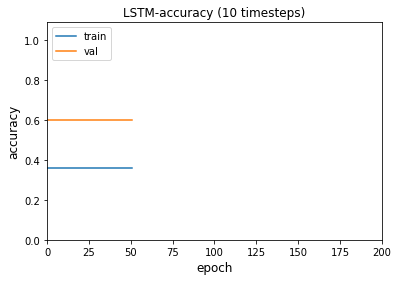

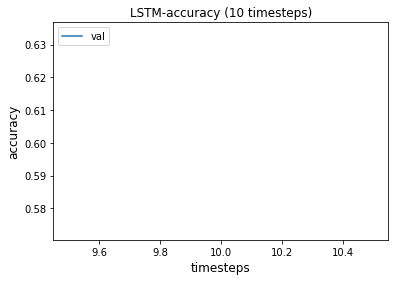

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
6771
212/212 [==============================] - 1s 4ms/step - loss: 0.3964 - accuracy: 0.6036
Test accuracy 0.6035888195037842
Test loss 0.3964144289493561
f1Score: ['n/a']
Accuracy: [0.6035888195037842]
PGD:	[0.6035888195037842]
 
############################################
Doing Timestep :20
############################################
Features: 15
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 164)               118080    
_________________________________________________________________
dense_1 (Dense)              (None, 

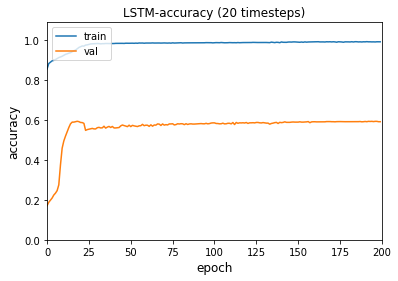

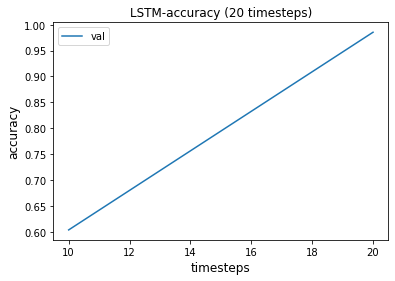

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
3385
106/106 [==============================] - 1s 5ms/step - loss: 0.0174 - accuracy: 0.9804
Test accuracy 0.9804283380508423
Test loss 0.017430083826184273
f1Score: ['n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271]
PGD:	[0.6035888195037842, 0.9804283380508423]
 
############################################
Doing Timestep :30
############################################
Features: 15
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 164)               118080    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 165       
To

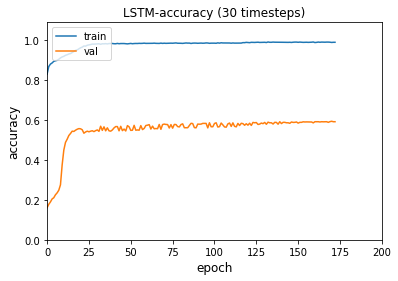

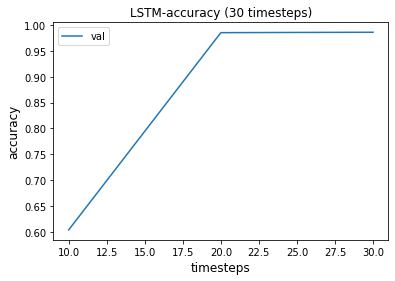

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
2257
71/71 [==============================] - 1s 5ms/step - loss: 0.0205 - accuracy: 0.9681
Test accuracy 0.9680845141410828
Test loss 0.02049734629690647
f1Score: ['n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828]
 
############################################
Doing Timestep :40
############################################
Features: 15
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 164)               118080    
_________________________________________________________________
dense_3 (Dense)         

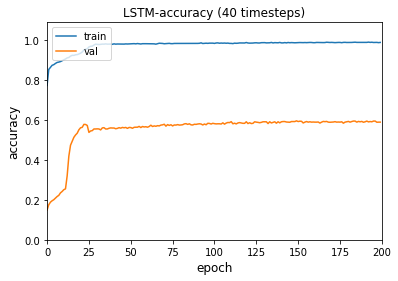

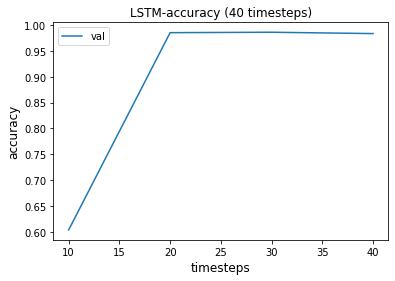

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
1692
53/53 [==============================] - 1s 6ms/step - loss: 0.0157 - accuracy: 0.9784
Test accuracy 0.9783540368080139
Test loss 0.01566588133573532
f1Score: ['n/a', 'n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786, 0.9836731553077698]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828, 0.9783540368080139]
 
############################################
Doing Timestep :50
############################################
Features: 15
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 164)               118080    
___________________________________________

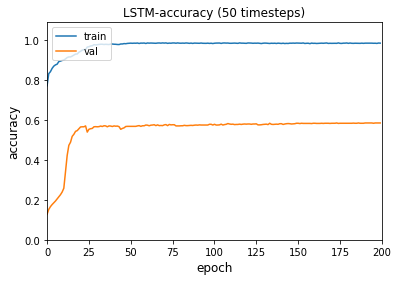

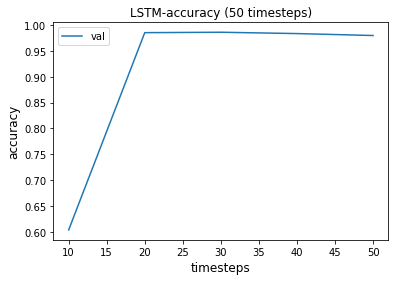

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
1354
43/43 [==============================] - 1s 7ms/step - loss: 0.0168 - accuracy: 0.9784
Test accuracy 0.9784491062164307
Test loss 0.016795771196484566
f1Score: ['n/a', 'n/a', 'n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786, 0.9836731553077698, 0.9799261689186096]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828, 0.9783540368080139, 0.9784491062164307]
 
############################################
Doing Timestep :60
############################################
Features: 15
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 164)               118080

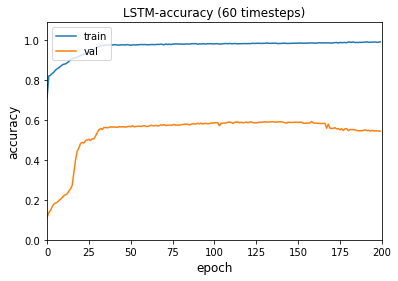

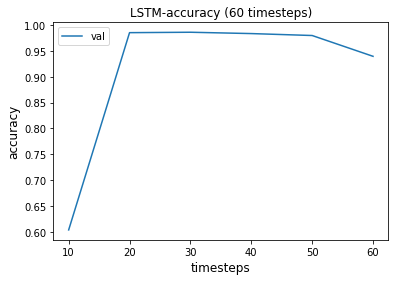

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
1128
36/36 [==============================] - 1s 8ms/step - loss: 0.0389 - accuracy: 0.9414
Test accuracy 0.941415548324585
Test loss 0.03888028487563133
f1Score: ['n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786, 0.9836731553077698, 0.9799261689186096, 0.9396424889564514]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828, 0.9783540368080139, 0.9784491062164307, 0.941415548324585]
 
############################################
Doing Timestep :70
############################################
Features: 15
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)    

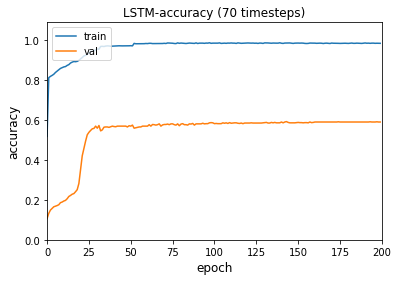

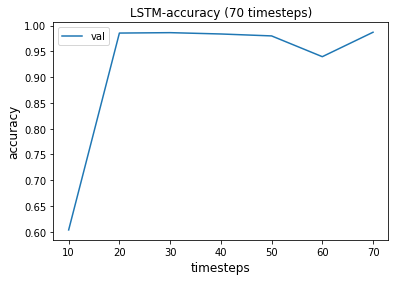

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
967
31/31 [==============================] - 1s 9ms/step - loss: 0.0130 - accuracy: 0.9870
Test accuracy 0.9870437979698181
Test loss 0.013041943311691284
f1Score: ['n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786, 0.9836731553077698, 0.9799261689186096, 0.9396424889564514, 0.9870437979698181]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828, 0.9783540368080139, 0.9784491062164307, 0.941415548324585, 0.9870437979698181]
 
############################################
Doing Timestep :80
############################################
Features: 15
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output

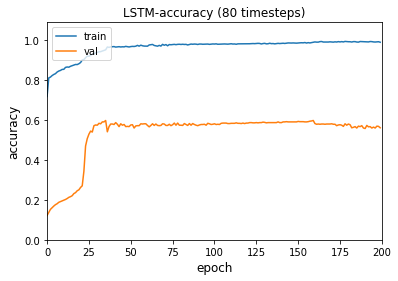

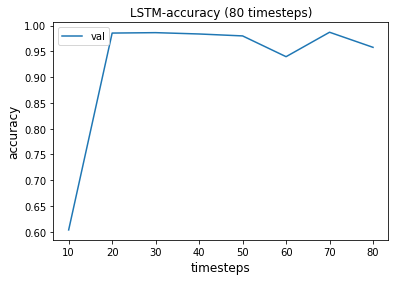

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
846
27/27 [==============================] - 1s 10ms/step - loss: 0.0285 - accuracy: 0.9566
Test accuracy 0.9565750956535339
Test loss 0.028541812673211098
f1Score: ['n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786, 0.9836731553077698, 0.9799261689186096, 0.9396424889564514, 0.9870437979698181, 0.9577571153640747]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828, 0.9783540368080139, 0.9784491062164307, 0.941415548324585, 0.9870437979698181, 0.9565750956535339]
 
############################################
Doing Timestep :90
############################################
Features: 15
Model: "sequential_8"
_____________________________________________________

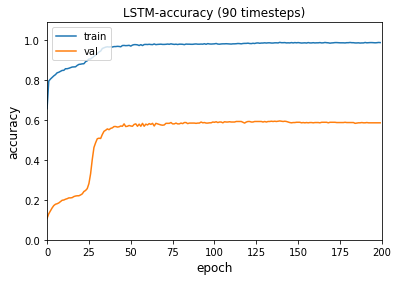

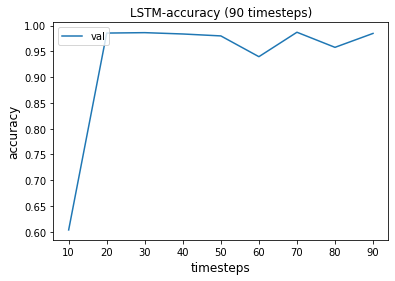

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
752
24/24 [==============================] - 1s 11ms/step - loss: 0.0150 - accuracy: 0.9848
Test accuracy 0.9847665429115295
Test loss 0.014965488575398922
f1Score: ['n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786, 0.9836731553077698, 0.9799261689186096, 0.9396424889564514, 0.9870437979698181, 0.9577571153640747, 0.9847665429115295]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828, 0.9783540368080139, 0.9784491062164307, 0.941415548324585, 0.9870437979698181, 0.9565750956535339, 0.9847665429115295]
 
############################################
Doing Timestep :100
############################################
Features: 15
Model: "sequential_9"
_____

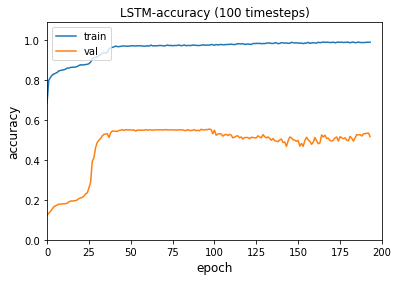

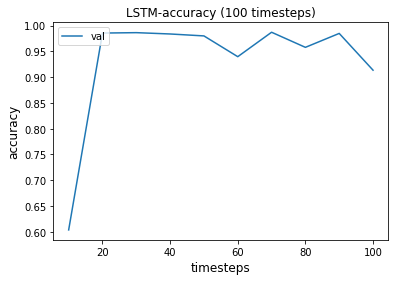

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
677
22/22 [==============================] - 1s 10ms/step - loss: 0.0790 - accuracy: 0.8655
Test accuracy 0.8654801249504089
Test loss 0.07903754711151123
f1Score: ['n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786, 0.9836731553077698, 0.9799261689186096, 0.9396424889564514, 0.9870437979698181, 0.9577571153640747, 0.9847665429115295, 0.9134564995765686]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828, 0.9783540368080139, 0.9784491062164307, 0.941415548324585, 0.9870437979698181, 0.9565750956535339, 0.9847665429115295, 0.8654801249504089]
 
############################################
Doing Timestep :110
#######################################

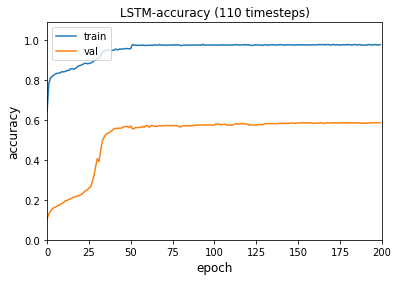

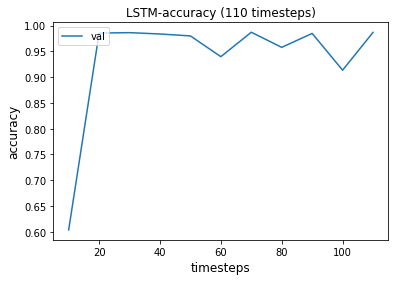

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
615
20/20 [==============================] - 1s 13ms/step - loss: 0.0139 - accuracy: 0.9835
Test accuracy 0.9835476875305176
Test loss 0.013886838220059872
f1Score: ['n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786, 0.9836731553077698, 0.9799261689186096, 0.9396424889564514, 0.9870437979698181, 0.9577571153640747, 0.9847665429115295, 0.9134564995765686, 0.9867997169494629]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828, 0.9783540368080139, 0.9784491062164307, 0.941415548324585, 0.9870437979698181, 0.9565750956535339, 0.9847665429115295, 0.8654801249504089, 0.9835476875305176]
 
############################################
Doing Times

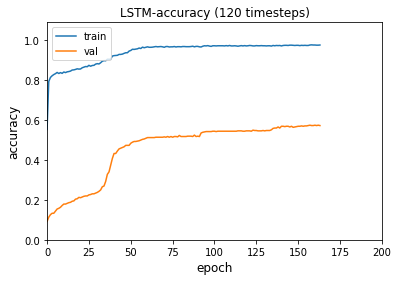

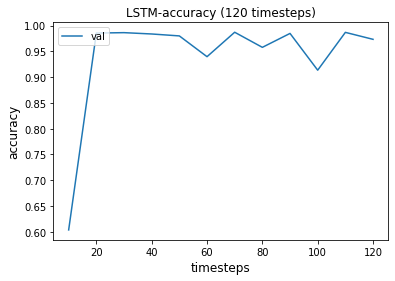

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
564
18/18 [==============================] - 1s 13ms/step - loss: 0.0350 - accuracy: 0.9449
Test accuracy 0.9449319839477539
Test loss 0.03496304899454117
f1Score: ['n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786, 0.9836731553077698, 0.9799261689186096, 0.9396424889564514, 0.9870437979698181, 0.9577571153640747, 0.9847665429115295, 0.9134564995765686, 0.9867997169494629, 0.9733008146286011]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828, 0.9783540368080139, 0.9784491062164307, 0.941415548324585, 0.9870437979698181, 0.9565750956535339, 0.9847665429115295, 0.8654801249504089, 0.9835476875305176, 0.9449319839477539]
 
##########

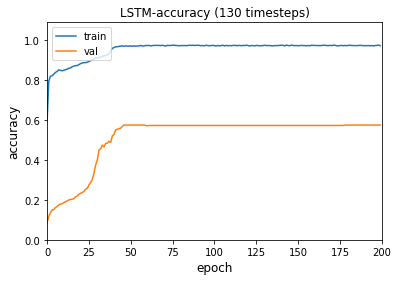

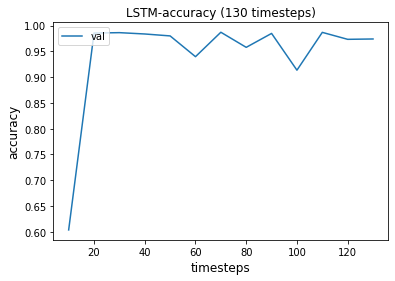

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
520
17/17 [==============================] - 1s 15ms/step - loss: 0.0182 - accuracy: 0.9740
Test accuracy 0.9739792346954346
Test loss 0.018197691068053246
f1Score: ['n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786, 0.9836731553077698, 0.9799261689186096, 0.9396424889564514, 0.9870437979698181, 0.9577571153640747, 0.9847665429115295, 0.9134564995765686, 0.9867997169494629, 0.9733008146286011, 0.9739792346954346]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828, 0.9783540368080139, 0.9784491062164307, 0.941415548324585, 0.9870437979698181, 0.9565750956535339, 0.9847665429115295, 0.8654801249504089, 0.9835476875305176, 0.94

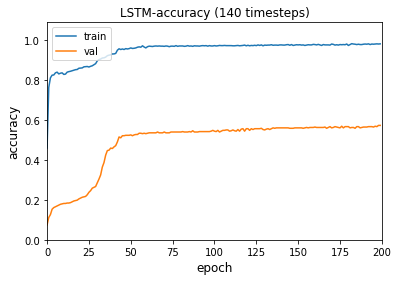

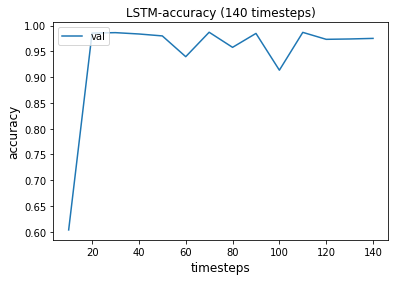

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
483
16/16 [==============================] - 1s 16ms/step - loss: 0.0313 - accuracy: 0.9627
Test accuracy 0.9626885652542114
Test loss 0.031274404376745224
f1Score: ['n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786, 0.9836731553077698, 0.9799261689186096, 0.9396424889564514, 0.9870437979698181, 0.9577571153640747, 0.9847665429115295, 0.9134564995765686, 0.9867997169494629, 0.9733008146286011, 0.9739792346954346, 0.9751109480857849]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828, 0.9783540368080139, 0.9784491062164307, 0.941415548324585, 0.9870437979698181, 0.9565750956535339, 0.9847665429115295, 0.865480124950408

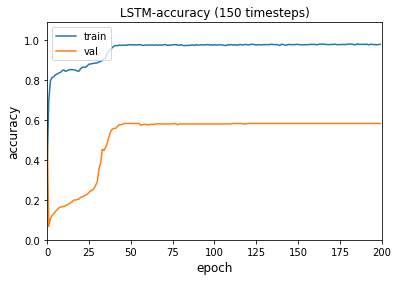

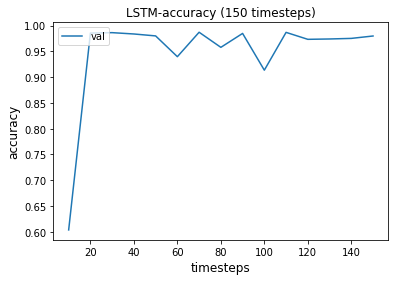

(67714, 15, 1)
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
0
(67714, 15, 1)
/usr/local/lib/python3.7/dist-packages/cleverhans/__init__.py

Tensorflow Version: 2.6.0
Cleverhans Version: 3.1.0-4c4f89778a89e8daf86fdb05f5e703b3
GPU Available:  True
451
15/15 [==============================] - 1s 15ms/step - loss: 0.0193 - accuracy: 0.9798
Test accuracy 0.9797634482383728
Test loss 0.0192697923630476
f1Score: ['n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786, 0.9836731553077698, 0.9799261689186096, 0.9396424889564514, 0.9870437979698181, 0.9577571153640747, 0.9847665429115295, 0.9134564995765686, 0.9867997169494629, 0.9733008146286011, 0.9739792346954346, 0.9751109480857849, 0.9797634482383728]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828, 0.9783540368080139, 0.9784491062164307, 0.941415548324585, 0.9870437979698181, 0.9565750956535339, 0.9847665429

In [ ]:






      

# #Network parameters

# timesteps_todo = [ 1 ]
# max_timesteps = 10
# by_increment = 1

# plot_timesteps = []
# unseen_test_accuracy = []
# unseen_loss = []


for timesteps in timesteps_todo:
  print(" ")
  print("############################################")
  print("Doing Timestep :" + str(timesteps))
  print("############################################")
  features = x_train.shape[1]
  print("Features: " + str(features))
  input_shape = (timesteps,features)
  
  units = (164)
  #dropout = (0.0)

  opt = keras.optimizers.SGD(learning_rate=0.01)

  model = tf.keras.models.Sequential()
  # model.add(tf.keras.layers.SimpleRNN(units=units, dropout=dropout, input_shape=input_shape))
  #model.add(tf.keras.layers.LSTM(units=units, dropout=dropout, input_shape=input_shape))
  # model.add(tf.keras.layers.LSTM(units=units, return_sequences = True, dropout=dropout, input_shape=input_shape))
  if(USE_RNN):
    model.add(tf.keras.layers.RNN(units=units, dropout=dropout, input_shape=input_shape))
    RNN_TYPE="RNN"

  if(USE_LSTM):
    model.add(tf.keras.layers.LSTM(units=units, dropout=dropout, input_shape=input_shape))
    RNN_TYPE="LSTM"

  if(USE_GRU):
    model.add(tf.keras.layers.GRU(units=units, dropout=dropout, input_shape=input_shape))
    RNN_TYPE="GRU"


  # model.add(LSTM(lstm_out, dropout_U = 0.2, dropout_W = 0.2))
  # model.add(tf.keras.layers.Dense(timesteps,activation='softmax'))
  if(COUNT_MAL_FLOWS):
    #Activation Function is linear to provide numeric output
    model.add(tf.keras.layers.Dense(1,activation='ReLU'))
    model.compile(loss = tf.keras.losses.MeanSquaredError(), optimizer=opt,metrics = ['accuracy'])
  else:
    #sigmoid 0 - 1
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    #model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy', tf.keras.metrics.TruePositives(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()])
    model.compile(loss = tf.keras.losses.MeanSquaredError(), optimizer=opt,metrics = ['accuracy', tf.keras.metrics.TruePositives(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()])
  print(model.summary())


  keras.utils.plot_model(model, show_shapes=True)

  # from tensorflow.keras.utils import to_categorical
  # #reshape for this timestep

  # #How many rows in x_train?
  # #How many groups of 10 Timesteps?

  print("There are " +str(len(x_train)) +" lines in x_train")
  print(str(len(x_train)) + " Divided by " + str(timesteps) + " gives remainder " +str(len(x_train) % timesteps))
  last_even_split = ((len(x_train)-1) - (len(x_train) -1) % timesteps )
  print("last even split: " +str(last_even_split))

  print("my_x_train==============================")
  my_x_train = x_train[0:last_even_split].reshape(-1, timesteps, features)
  print(my_x_train)
  print(my_x_train.shape)

  print("my_y_train==============================")
  my_y_train = y_train[0:last_even_split].reshape(-1,timesteps)
  sequence_my_y_train = []
  print(my_y_train)
  print(my_y_train.shape)


  print("=================================================")
  print("Working with "  +str(timesteps) + " Timesteps... ")

  
  if(timesteps > 1):
    print("Processing y train samples for sequences")
    for seq in range(len(my_y_train)):
      
      if( 1 in my_y_train[seq]):
        orig_my_y_train = my_y_train[seq]
        sequence_my_y_train.append(1)
        # print("`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`")
        # print("original: "+ str(orig_my_y_train) + " Modified " + str(sequence_my_y_train[seq]))
      else:
        orig_my_y_train = my_y_train[seq]
        sequence_my_y_train.append(0)
        # print("`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`")
        # print("original: "+ str(orig_my_y_train) + " Modified " + str(sequence_my_y_train[seq]))
      
    sequence_my_y_train = np.array(sequence_my_y_train)
    print("Done processing y train samples")
    print(sequence_my_y_train)

  print("Now processing y test ")
  last_even_split = ((len(y_test)-1) - (len(y_test) -1) % timesteps )
  # print(last_even_split)
  
  
  my_x_test = x_test[0:last_even_split].reshape(-1,timesteps,features)
  my_y_test = y_test[0:last_even_split].reshape(-1,timesteps)
  
  #declare sequence_my_y_test before calling the function.
  sequence_my_y_test = []

  #IfAnyMalMarkSeqMal()
  CountofMalSamplesIn()
  
  # print("Resetting sequence_my_y_test")
  # if(timesteps > 1):
  #   print("Timesteps > 1 :" + str(timesteps))
  #   print("for loop in range: " + str(range(len(my_y_test))))
  #   for seq in range(len(my_y_test)):
  #     #print("in the actual loop")
  #     # print(my_y_train[seq])
  #     list_to_check = my_y_test[seq].tolist()
  #     if(list_to_check.count(1) > 0 ):
  #       orig_my_y_train = my_y_test[seq]
  #       sequence_my_y_test.append(list_to_check.count(1))
  #       # print("`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`")
  #       # print("original: "+ str(orig_my_y_train) + " Modified " + str(sequence_my_y_train[seq]))
  #     else:
  #       orig_my_y_train = my_y_test[seq]
  #       sequence_my_y_test.append(0)
  #       # print("`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`/`")
  #       # print("original: "+ str(orig_my_y_train) + " Modified " + str(sequence_my_y_train[seq]))

  sequence_my_y_test = np.array(sequence_my_y_test)
  if(DEBUG):
    print("Sanity Check")
    print("x_test_shape " + str(x_test.shape))
    print("y_test_shape " + str(y_test.shape))
    print("my_x_test_shape " + str(my_x_test.shape))
    print("my_y_test_shape " + str(my_y_test.shape))
  
    for seq in range(len(my_y_test)):
      if(timesteps == 1):
        print(str(my_y_test[seq]) + "->" + str(my_y_test[seq]))
      else:
        if(sequence_my_y_test[seq] != 0):
          print(str(my_y_test[seq]) + "->" + str(sequence_my_y_test[seq]))
  


  # print(my_x_test)
  # print("========================")
  # print(my_y_test)

  # my_x_test = x_test[0:last_even_split].reshape(-1,timesteps,features)

  #epochs = 50
  batch_size = batchSize

  best_model_filename = "best_model_timesteps" + str(timesteps) +".h5"

  callbacks = [
       keras.callbacks.ModelCheckpoint(
           best_model_filename, save_best_only=True, monitor="val_loss"
       ),
       keras.callbacks.ReduceLROnPlateau(
           monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
       ),
       keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
   ]
  
  
  print(" ")
  print("Fitting the model....")


  if(timesteps == 1):
    history = model.fit(
       #ThreeD_x_train,
       my_x_train,
       # y_train,
       my_y_train,
       #batch_size=batch_size,
       epochs=epochs,
       callbacks=callbacks,
       shuffle=False,
       #validation_split=0.20,
       validation_data=(my_x_test, my_y_test),
       verbose=1,


    )
    
    # model = keras.models.load_model("best_model.h5")
    #model = keras.models.load_model(best_model_filename)
    
    if(COUNT_MAL_FLOWS):
      test_loss, test_acc = model.evaluate(my_x_test, my_y_test)
      f1Score = 'n/a'
    else:
      test_loss, test_acc, truePositives, falsePositives, falseNegatives = model.evaluate(my_x_test, my_y_test)
      f1Score = (truePositives/   (truePositives +((1/2) * (falsePositives + falseNegatives))))

    if(DEBUG):
      yhat = []
    
      yhat = model.predict(my_x_test) 
      for x in range(len(my_x_test)):
        print(str(y_test[x]) + " -> " + str(yhat[x]))
    
    
      


    

  elif (timesteps != 1):
    history = model.fit(
       #ThreeD_x_train,
       my_x_train,
       # y_train,
       sequence_my_y_train,
       batch_size=batch_size,
       epochs=epochs,
       callbacks=callbacks,
       shuffle=False,
       #validation_split=0.20,
       validation_data=(my_x_test, sequence_my_y_test),
       verbose=1,
    )
    #model = keras.models.load_model(best_model_filename)
    if(COUNT_MAL_FLOWS):
      test_loss, test_acc = model.evaluate(my_x_test, my_y_test)
      f1Score = 'n/a'
    else:
      test_loss, test_acc, truePositives, falsePositives, falseNegatives = model.evaluate(my_x_test, sequence_my_y_test)
      f1Score = (truePositives/   (truePositives +((1/2) * (falsePositives + falseNegatives))))

    yhat = []
    matches = 0
    differences = 0
    malicious_and_predicted_malicious = 0 
    
    yhat = model.predict(my_x_test) 
    for x in range(len(my_x_test)):
      if(sequence_my_y_test[x] != yhat[x]):
        differences = differences +1
        #print(str(sequence_my_y_test[x]) + " -> " + str(yhat[x]))
      elif((sequence_my_y_test[x] > yhat[x]) and (yhat[x] > 0)):
        #print(str(sequence_my_y_test[x]) + " -> " + str(yhat[x]))
        malicious_and_predicted_malicious = malicious_and_predicted_malicious +1
      else:
        #print(str(sequence_my_y_test[x]) + " -> " + str(yhat[x]))
        matches = matches +1
    
    print("Matches:\t" + str(matches))
    print("Correctly Malicious:\t" + str(malicious_and_predicted_malicious))
    print("Differences:\t" + str(differences))

    # opening the csv file in 'w+' mode
    file = open('mount/My Drive/Colab Notebooks/predictions.csv', 'w', newline ='')
  
    # writing the data into the file
    with file:    
      write = csv.writer(file)
      write.writerows(yhat)


    print("Test accuracy", test_acc)
    print("Test loss", test_loss)
    print("f1Score: " + str(f1Score))

  f1Scores.append(f1Score)
  plot_timesteps.append(timesteps)
  unseen_test_accuracy.append(test_acc)
  unseen_loss.append(test_loss)
  metric = "accuracy"


  plt.figure()
  plt.plot(history.history[metric])
  plt.plot(history.history["val_" + metric])
  plt.title(RNN_TYPE + "-" + metric + " (" +str(timesteps) + " timesteps)")
  plt.ylabel(metric, fontsize="large")
  plt.xlabel("epoch", fontsize="large")
  plt.legend(["train", "val"], loc="upper left")
  plt.ylim(0.0, 1.09)
  plt.xlim(0,(epochs))


  fig1 = plt.gcf()
  plt.draw()
  filename='mount/My Drive/Colab Notebooks/Figures/' + RNN_TYPE +'original-ts' + str(timesteps) + '-Epochs'+ str(epochs) +'.png' 
  plt.savefig(filename,dpi=300)
  plt.show()
  plt.close()

  plt.plot(plot_timesteps, unseen_test_accuracy)
  plt.title(RNN_TYPE + "-" + metric + " (" +str(timesteps) + " timesteps)")
  plt.ylabel(metric, fontsize="large")
  plt.xlabel("timesteps", fontsize="large")
  plt.legend(["val"], loc="upper left")
  fig2 = plt.gcf()
  plt.draw()
  filename='mount/My Drive/Colab Notebooks/Figures/Unseen-Accuracy' + str(timesteps) +'.png' 
  plt.savefig(filename,dpi=300)
  
  plt.show()
  plt.close()

  if(DO_THE_ADVERSARIAL_EXAMPLE):

    #The attack requires the model to ouput the logits
    logits_model = keras.Model(model.input,model.layers[-1].output)

    # Batch run on all test data

    CLASS_TO_CHANGE = 1 # 1 will make all true cases appear as false (DDoS -> Benign)

    #df2 = pd.DataFrame(min_max_scaler.fit_transform(subset), columns=subset.columns, index=subset.index)

    X_adv = np.zeros(my_x_test.shape)

    print (x_test.shape)
    headers = df2.columns[:80]
    printheaders =True
    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
    print(Y_class[0])
    print(x_test.shape)


    stop_percentage = 100
    !pip install cleverhans==3.1.0
    # Install bleeding edge version of cleverhans
    # !pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

    # import sys
    # # sys.path.append('/opt/anaconda3/envs/CleanPy38/lib/python3.8/site-packages/cleverhans')

    # sys.path.append('/Users/a23-mccarthy/.local/lib/python3.8/site-packages/')

    from tensorflow.python.ops.numpy_ops import np_config
    np_config.enable_numpy_behavior()
    import cleverhans
    print(cleverhans.__file__)
    

    print("\nTensorflow Version: " + tf.__version__)
    print("Cleverhans Version: " + cleverhans.__version__)
    print("GPU Available: ", tf.test.is_gpu_available())

    # Import the attacks
    from cleverhans.future.tf2.attacks import fast_gradient_method
    from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

    #num_features = 58 -- commented out
    num_samples = my_x_test.shape[0]
    print(num_samples)
    for i in range(my_x_test.shape[0]):
        current_class = my_y_test[i]
        #print("Class:", current_class)
        #print(x_test[0,:])
        if(timesteps == 1):
          if current_class == CLASS_TO_CHANGE:
              # print("###### Performing FGSM #######")
              # example_vals = x_test[i, :]
              example_vals = my_x_test[i, :]
              #print(example_vals)
              example_labels = my_y_test[i]
              #print(example_labels)
              example_vals = tf.convert_to_tensor(example_vals.reshape((-1,timesteps, features)))
              example_labels = np.reshape(example_labels, (1,)).astype('int64')
              #epsilon = 0.5
              if(DO_FGSM):
                adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, targeted=False)
                adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
              if(DO_PGD):
                adv_example_untargeted_label = projected_gradient_descent(model, example_vals, epsilon, 0.01, 40, np.inf)
                adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)


              # print(X_adv.shape)
              # print(X_adv[i,:].shape)
              # print(adv_example_untargeted_label.shape)
              X_adv[i,:] = adv_example_untargeted_label.reshape(timesteps, features)
              my_x_test[i,:] = adv_example_untargeted_label.reshape(timesteps, features)

              #print (example_labels, "--->", np.argmax(adv_example_untargeted_label_pred))
              #print(X_test[i,:])
              #df2 = pd.DataFrame(min_max_scaler.fit_transform(subset), columns=subset.columns, index=subset.index)
              #ae_ddos_to_benign =pd.DataFrame(X_adv.reshape(-1,58,timesteps))
              # print(ae_ddos_to_benign)
              percentage = (i/num_samples * 100)
              #print(percentage)
        
              if(percentage > stop_percentage):
                print("Working on: " + str(i) + " of " + str(num_samples) + " " + str(int(percentage)) +"%")
                if(i != 0):
                  break
          
              if(percentage %2 == 0):
                print("Working on: " + str(i) + " of " + str(num_samples) + " " + str(int(percentage)) +"%")

        
              #print(subset.columns)
              #, columns=subset.columns, index=subset.index
              #print(subset.columns)
              #if(printheaders):
              #  outputfile.to_csv('mount/My Drive/Colab Notebooks/network_data/my_adversarial.csv', mode='a', header=headers)
              #else: 
              #  outputfile.to_csv('mount/My Drive/Colab Notebooks/network_data/my_adversarial.csv', mode='a')
              printheaders = False
              #inverted.to_csv('mount/My Drive/Colab Notebooks/network_data/my_inverted.csv', mode='a', header=headers)

        elif(timesteps > 1):
          if current_class.any == CLASS_TO_CHANGE:
              # print("###### Performing FGSM #######")
              # example_vals = x_test[i, :]
              example_vals = my_x_test[i, :]
              #print(example_vals)
              example_labels = my_y_test[i]
              #print(example_labels)
              example_vals = tf.convert_to_tensor(example_vals.reshape((-1, timesteps, features)))
              example_labels = np.reshape(example_labels, (1,)).astype('int64')
              #epsilon = 0.5
              if(DO_FGSM):
                adv_example_untargeted_label = fast_gradient_method(logits_model, example_vals, epsilon, np.inf, targeted=False)
                adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
              if(DO_PGD):
                adv_example_untargeted_label = projected_gradient_descent(model, example_vals, epsilon, 0.01, 40, np.inf)
                adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)



              # print(X_adv.shape)
              # print(X_adv[i,:].shape)
              # print(adv_example_untargeted_label.shape)
              X_adv[i,:] = adv_example_untargeted_label.reshape(timesteps, features)
              my_x_test[i,:] = adv_example_untargeted_label.reshape(timesteps, features)

              #print (example_labels, "--->", np.argmax(adv_example_untargeted_label_pred))
              #print(X_test[i,:])
              #df2 = pd.DataFrame(min_max_scaler.fit_transform(subset), columns=subset.columns, index=subset.index)
              #ae_ddos_to_benign =pd.DataFrame(X_adv.reshape(-1,58,timesteps))
              # print(ae_ddos_to_benign)
              percentage = int(i/num_samples * 100)
              #print(percentage)
        
              if(percentage >= stop_percentage):
                print("Working on: " + str(i) + " of " + str(num_samples) + " " + str(percentage) +"%")
                if(i != 0):
                  break
              elif(percentage %2 == 0):
                print("Working on: " + str(i) + " of " + str(num_samples) + " " + str(percentage) +"%")

        
              #print(subset.columns)
              #, columns=subset.columns, index=subset.index
              #print(subset.columns)
              #if(printheaders):
              #  outputfile.to_csv('mount/My Drive/Colab Notebooks/network_data/my_adversarial.csv', mode='a', header=headers)
              #else: 
              #  outputfile.to_csv('mount/My Drive/Colab Notebooks/network_data/my_adversarial.csv', mode='a')
              printheaders = False
              #inverted.to_csv('mount/My Drive/Colab Notebooks/network_data/my_inverted.csv', mode='a', header=headers)


    model = keras.models.load_model(best_model_filename)

    # samples_to_test = 1600 * stop_percentage

    # test_loss, test_acc = model.evaluate(my_x_test[0:samples_to_test], my_y_test[0:samples_to_test])


    if(timesteps > 1):
      if(COUNT_MAL_FLOWS):
        test_loss, test_acc = model.evaluate(my_x_test, my_y_test)
        f1Score = 'n/a'
      else:
        ### test_loss, test_acc, truePositives, falsePositives, falseNegatives = model.evaluate(my_x_test, my_y_test)
        f1Score = (truePositives/   (truePositives +((1/2) * (falsePositives + falseNegatives))))
        test_loss, test_acc, truePositives, falsePositives, falseNegatives = model.evaluate(my_x_test, sequence_my_y_test)

      
      advx_accuracy.append(test_acc)
      advx_f1Scores.append(f1Score)

      print("Test accuracy", test_acc)
      print("Test loss", test_loss)
      print("f1Score: " + str(advx_f1Scores))

      print("Accuracy: " + str(unseen_test_accuracy))
      if(DO_FGSM):
        print("FGSM:\t" + str(advx_accuracy))
      if(DO_PGD):
        print("PGD:\t" + str(advx_accuracy))
      if(DO_JSMA):
        print("JSMA:\t" + str(advx_accuracy))
    
    if(timesteps == 1):
      if(COUNT_MAL_FLOWS):
          test_loss, test_acc = model.evaluate(my_x_test, my_y_test)
          f1Score = 'n/a'
      else:
        test_loss, test_acc, truePositives, falsePositives, falseNegatives = model.evaluate(my_x_test, my_y_test)
        f1Score = (truePositives/   (truePositives +((1/2) * (falsePositives + falseNegatives))))

      

      advx_accuracy.append(test_acc)
      advx_f1Scores.append(f1Score)

      print("Test accuracy", test_acc)
      print("Test loss", test_loss)
      print("Advx f1Score: " + str(advx_f1Scores))

      print("Accuracy: " + str(unseen_test_accuracy))
      if(DO_FGSM):
        print("FGSM:\t" + str(advx_accuracy))
      if(DO_PGD):
        print("PGD:\t" + str(advx_accuracy))
      if(DO_JSMA):
        print("JSMA:\t" + str(advx_accuracy))
    

## Plot Graphs

15/15 [==============================] - 0s 15ms/step - loss: 0.0193 - accuracy: 0.9798
Test accuracy 0.9797634482383728
Test loss 0.0192697923630476
f1Score: ['n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a', 'n/a']
Accuracy: [0.6035888195037842, 0.9854505062103271, 0.9862502217292786, 0.9836731553077698, 0.9799261689186096, 0.9396424889564514, 0.9870437979698181, 0.9577571153640747, 0.9847665429115295, 0.9134564995765686, 0.9867997169494629, 0.9733008146286011, 0.9739792346954346, 0.9751109480857849, 0.9797634482383728]
PGD:	[0.6035888195037842, 0.9804283380508423, 0.9680845141410828, 0.9783540368080139, 0.9784491062164307, 0.941415548324585, 0.9870437979698181, 0.9565750956535339, 0.9847665429115295, 0.8654801249504089, 0.9835476875305176, 0.9449319839477539, 0.9739792346954346, 0.9626885652542114, 0.9797634482383728]


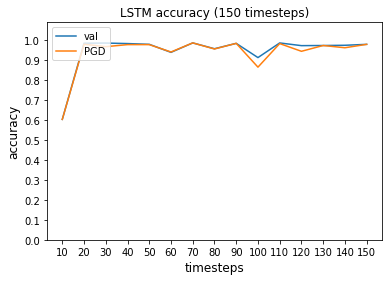

Error: ignored

In [ ]:

if(timesteps > 1):
  if(COUNT_MAL_FLOWS):
      test_loss, test_acc = model.evaluate(my_x_test, my_y_test)
  else:
    test_loss, test_acc, truePositives, falsePositives, falseNegatives = model.evaluate(my_x_test, sequence_my_y_test)
    f1Score = (truePositives/   (truePositives +((1/2) * (falsePositives + falseNegatives))))
      

  print("Test accuracy", test_acc)
  print("Test loss", test_loss)
  print("f1Score: " + str(advx_f1Scores))

  print("Accuracy: " + str(unseen_test_accuracy))
  if(DO_FGSM):
    print("FGSM:\t" + str(advx_accuracy))
  if(DO_PGD):
    print("PGD:\t" + str(advx_accuracy))
  if(DO_JSMA):
    print("JSMA:\t" + str(advx_accuracy))
    
if(timesteps == 1):
  test_loss, test_acc, truePositives, falsePositives, falseNegatives = model.evaluate(my_x_test, my_y_test)
  f1Score = (truePositives/   (truePositives +((1/2) * (falsePositives + falseNegatives))))


  print("Test accuracy", test_acc)
  print("Test loss", test_loss)
  print("Advx f1Score: " + str(advx_f1Scores))

  print("Accuracy: " + str(unseen_test_accuracy))
  if(DO_FGSM):
    print("FGSM:\t" + str(advx_accuracy))
  if(DO_PGD):
    print("PGD:\t" + str(advx_accuracy))
  if(DO_JSMA):
    print("JSMA:\t" + str(advx_accuracy))




plt.plot(plot_timesteps, unseen_test_accuracy)
plt.plot(plot_timesteps, advx_accuracy)
plt.title(RNN_TYPE + " " + metric + " (" +str(timesteps) + " timesteps)")
plt.ylabel(metric, fontsize="large")
plt.xlabel("timesteps", fontsize="large")
plt.xticks(plot_timesteps)
if(DO_FGSM):
  plt.legend(["val", "FGSM"], loc="upper left")
if(DO_PGD):
  plt.legend(["val", "PGD"], loc="upper left")
if(DO_JSMA):
  plt.legend(["val", "JSMA"], loc="upper left")

plt.ylim(0.0, 1.09)
#plt.yticks(0.0,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00)
plt.yticks([0.0,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,1.00]) # use square brackets

fig2 = plt.gcf()
plt.draw()

filename='mount/My Drive/Colab Notebooks/Figures/'
if(COUNT_MAL_FLOWS):
  filename=filename+'CountMalFlows'
if(IF_ANY_MAL_SEQ_MAL):
  filename=filename+'IfAnyMalSeqMal'
if(DO_FGSM):
  filename=filename + RNN_TYPE + 'FGSM_accuracy' + str(timesteps) +'.png' 
if(DO_PGD):
  filename=filename + RNN_TYPE + 'PGD_accuracy' + str(timesteps) +'.png' 
if(DO_JSMA):
  filename=filename + RNN_TYPE + 'JSMA_accuracy' + str(timesteps) +'.png' 

plt.savefig(filename,dpi=300)
  
plt.show()
plt.close()

import csv
  

  
# opening the csv file in 'w+' mode
csvfile = open(filename +'.csv', 'w', newline ='')
  
# writing the data into the file
with csvfile:    
    write = csv.writer(csvfile)
    for ts in plot_timesteps:
      write.writerows([ts])
    for uta in unseen_test_accuracy:
      write.writerows([uta])
    for advx_acc in advx_accuracy:
      write.writerows([advx_acc])
